# Handwritten digits recognition

The loader for the MNIST image data was taken from Nielsen's online book,

http://neuralnetworksanddeeplearning.com/chap1.html

See specifically the following link, for downloading the MNIST image data (we only need the mnist.pkl.gz package inside the 'data' subdirectory; store it inside the present directory of the notebook):
https://github.com/mnielsen/neural-networks-and-deep-learning/archive/master.zip


In [25]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianDropout
import tensorflow.keras.optimizers as optimizers

# Import the numpy library for matrix manipulations etc.

#from numpy import *
from numpy import array, zeros, exp, random, dot, shape, transpose, reshape, meshgrid, linspace, sqrt

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = random.RandomState(23455)

import time

In [4]:
"""
mnist_loader
~~~~~~~~~~~~

taken from Nielsen's online book:
http://neuralnetworksanddeeplearning.com/chap1.html


A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    tr_d, va_d, te_d = load_data()
    
    num_samples=len(tr_d[0])
    training_inputs=zeros([num_samples,numpixels])
    training_results=zeros([num_samples,10])    
    for j in range(num_samples):
        training_inputs[j,:] = reshape(tr_d[0][j], (numpixels))
        training_results[j,:] = vectorized_result(tr_d[1][j])
#    validation_inputs = [reshape(x, (numpixels)) for x in va_d[0]]
#    validation_results = [vectorized_result(y) for y in va_d[1]]

    num_test_samples=len(te_d[0])
    test_inputs=zeros([num_test_samples,numpixels])
    test_results=zeros([num_test_samples,10])    
    for j in range(num_test_samples):
        test_inputs[j,:] = reshape(te_d[0][j], (numpixels))
        test_results[j,:] = vectorized_result(te_d[1][j])

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = zeros((10))
    e[j] = 1.0
    return e

In [5]:
# initialize the network
def init_net():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(30, input_shape=(numpixels,), activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [6]:
# initialize the network
def init_net_large():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(100, input_shape=(numpixels,), activation='relu'))
    net.add(GaussianDropout(0.1))
    net.add(Dense(50, activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [7]:
def test_on(start,stop,dontprint=False):
    global test_inputs, test_results
    global net, predictions_probs, predictions, true_labels
    
    predictions_probs=net.predict_on_batch(test_inputs[start:stop,:])
    predictions=argmax(predictions_probs,axis=1)
    if dontprint==False:
        print("Predictions: ", predictions)
    true_labels=argmax(test_results[start:stop,:], axis=1)
    if dontprint==False:
        print("True labels: ", true_labels)

In [8]:
def display_image(which):
    global test_inputs
    
    plt.imshow(reshape(test_inputs[which,:],[28,28]),interpolation='nearest', cmap='binary')
    plt.show()

In [9]:
def display_image_array(which):
    global test_inputs
    
    numcolumns=8
    BigImage=zeros([28*numcolumns,28*numcolumns])
    for j in range(len(which)):
        x=(j%numcolumns)*28
        y=int(j/numcolumns)*28
        BigImage[x:x+28,y:y+28]=reshape(test_inputs[which[j],:],[28,28])
    plt.imshow(BigImage,interpolation='nearest', cmap='binary')
    plt.show()

In [10]:
def display_mistakes(maxnum):
    global test_inputs, rest_results, num_test_samples
    global true_labels, predictions, predictions_probs
    
    test_on(0,num_test_samples,dontprint=True)
    which=where(true_labels!=predictions)[0]
    for j in which:
        if j<maxnum:
            display_image(j)
            print("True ", true_labels[j], " - Predicted ", predictions[j], " with prob. ", predictions_probs[j,predictions[j]])
        

## Test out things

In [11]:
numpixels=784
load_data_wrapper() # load all the MNIST images

In [12]:
shape(training_inputs)

(50000, 784)

In [13]:
psi=training_inputs-sum(training_inputs,axis=0)/num_samples

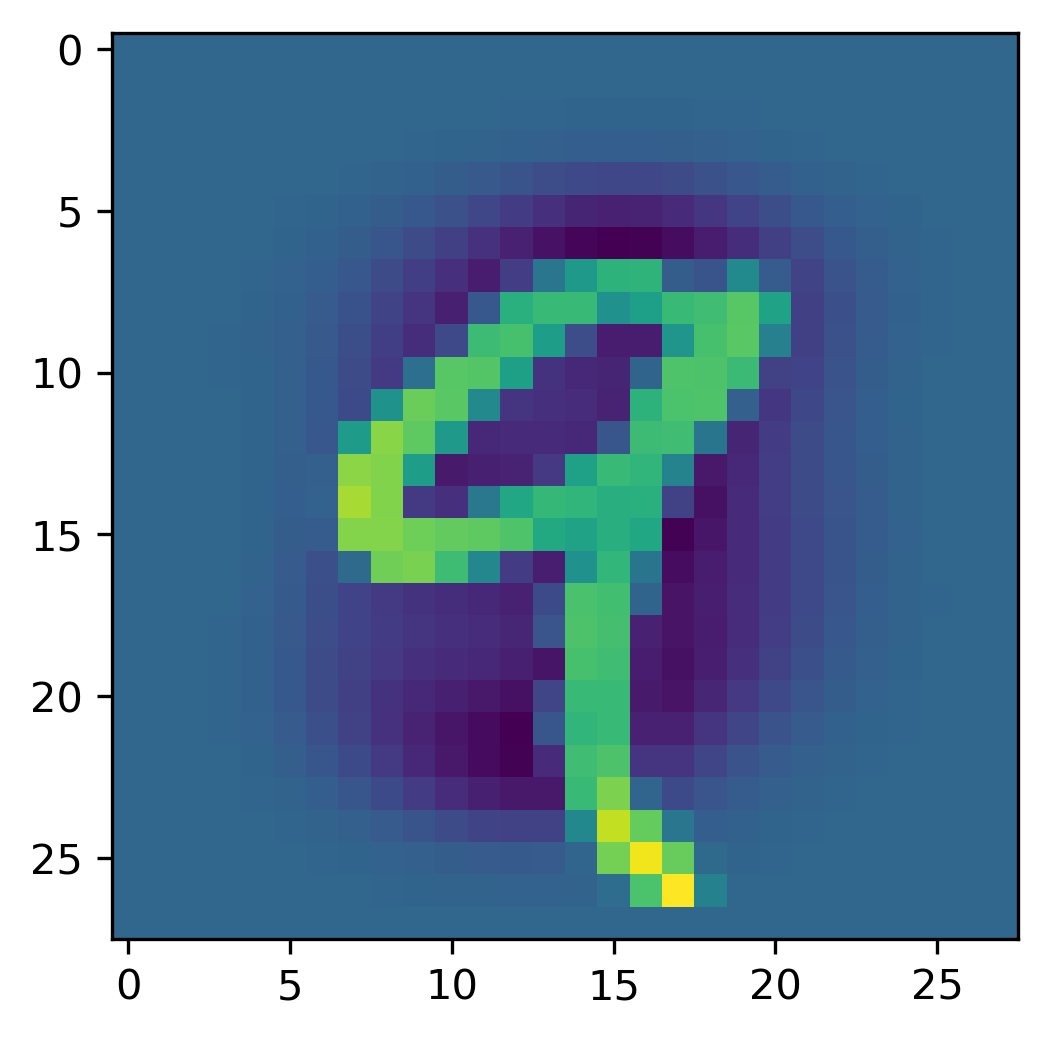

In [14]:
plt.imshow(reshape(psi[4,:],[28,28]))

In [15]:
shape(psi)

(50000, 784)

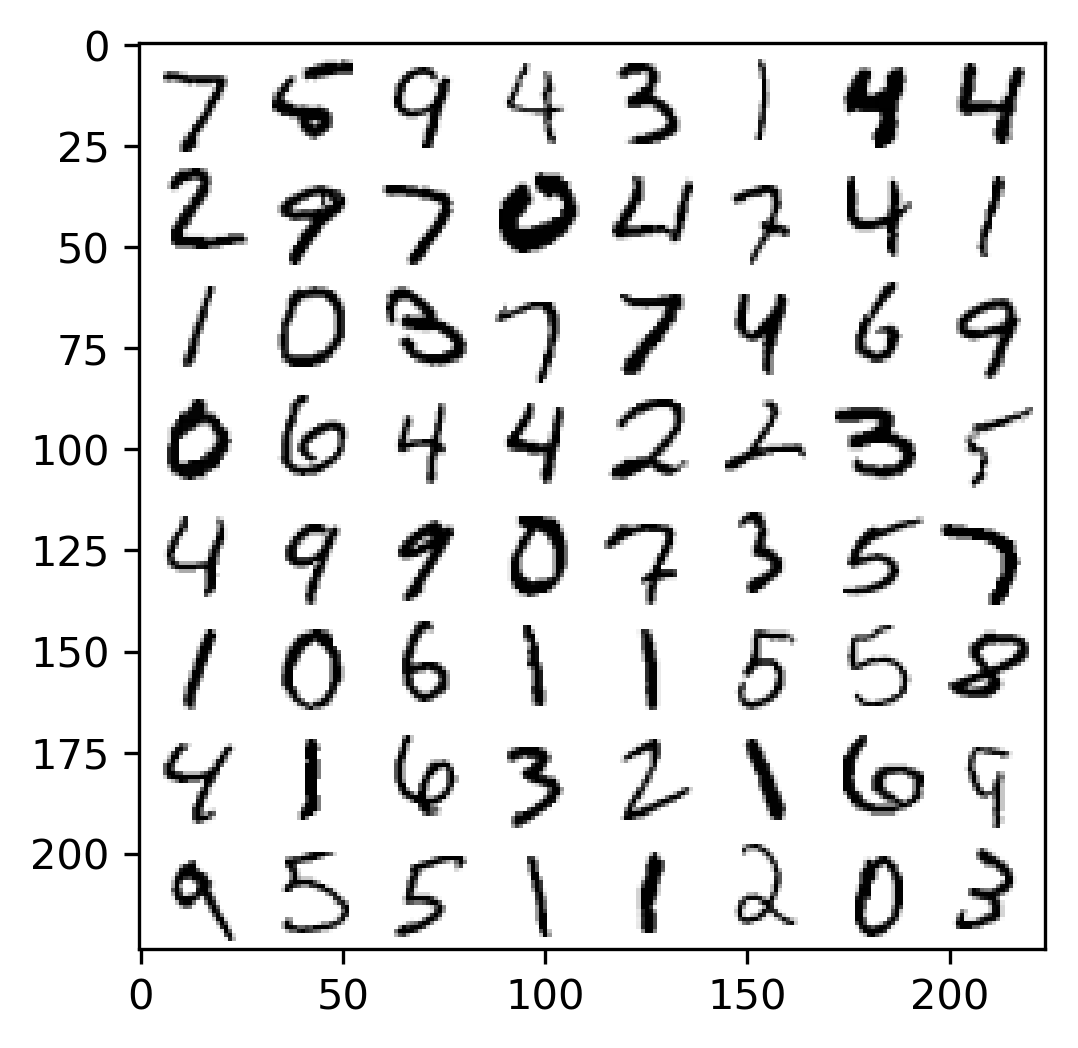

In [26]:
display_image_array(range(8*8))

In [27]:
shape(training_inputs)

(50000, 784)

In [28]:
init_net()

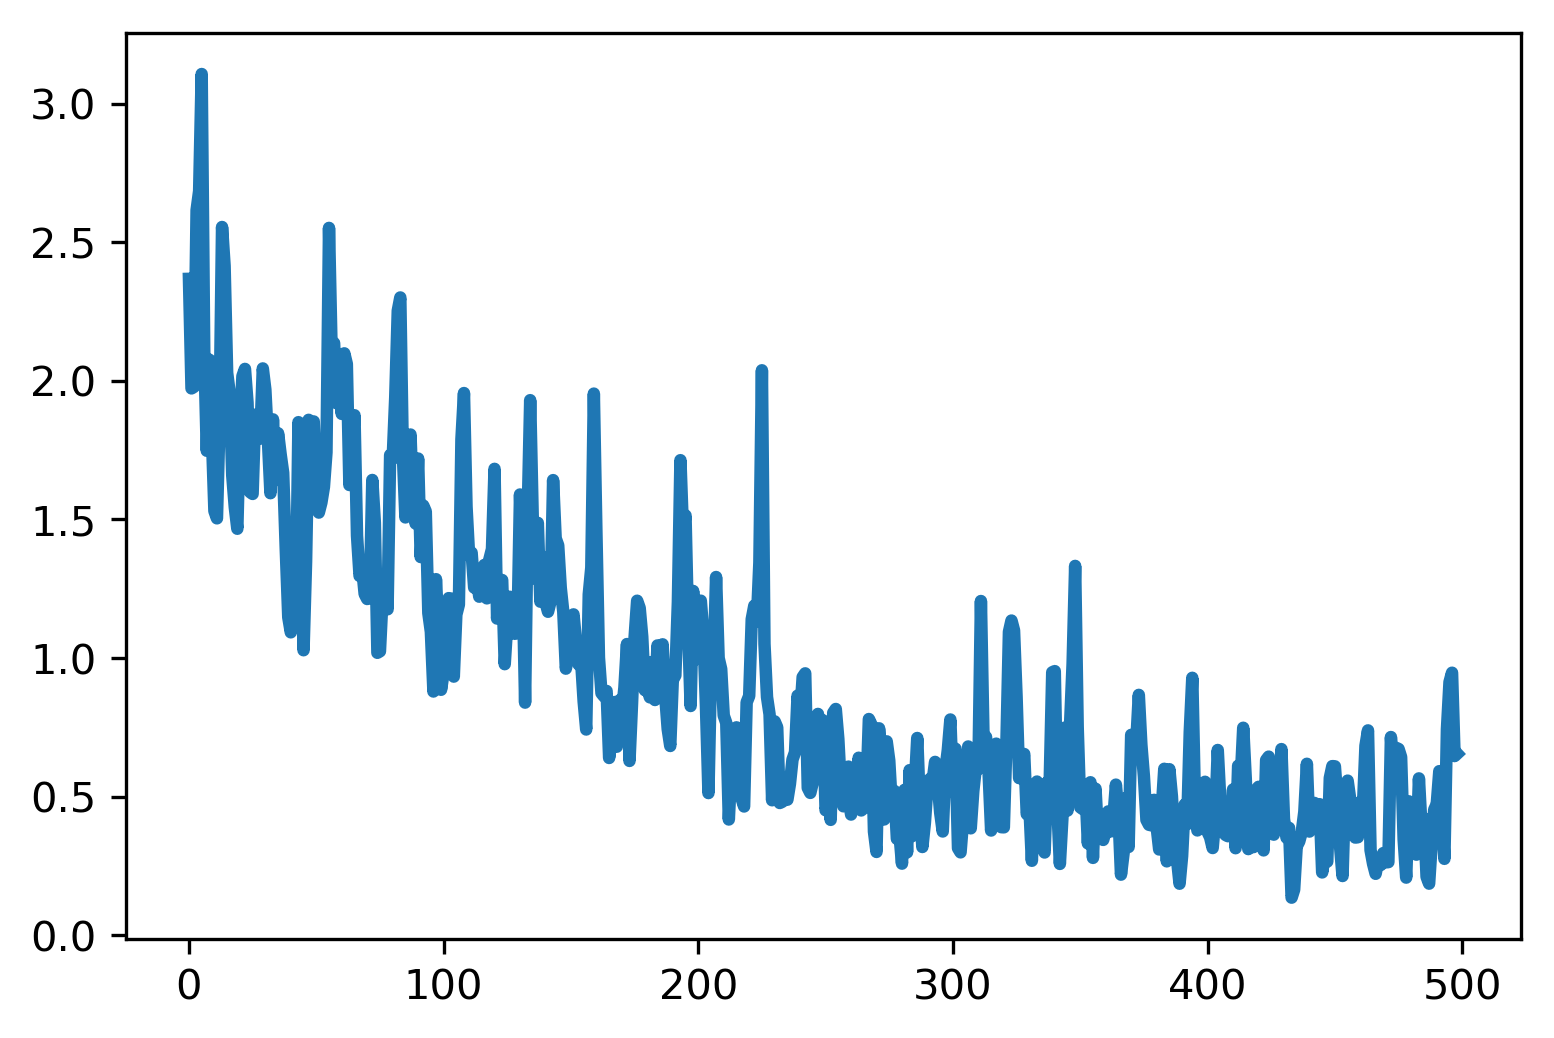

In [29]:
batchsize=100
batches=int(num_samples/batchsize)-1
costs=zeros(batches)
for j in range(batches):
    costs[j]=net.train_on_batch(training_inputs[j*batchsize:(j+1)*batchsize,:], training_results[j*batchsize:(j+1)*batchsize,:])[0]
plt.plot(costs,linewidth=3)
plt.show()

In [30]:
test_on(0,20)

Predictions:  [7 3 1 0 4 1 4 4 6 9 0 8 9 0 1 5 9 7 3 4]
True labels:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [31]:
# use the keras "fit" function to go through the whole data set many times ('epochs'), 
# and even set aside some validation samples
history=net.fit(training_inputs,training_results,batch_size=100,
                epochs=30,validation_split=0.1)

Epoch 1/30
450/450 [==============================] - 1s 2ms/step - loss: 0.3496 - categorical_accuracy: 0.8998 - val_loss: 0.3399 - val_categorical_accuracy: 0.9046
Epoch 2/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2975 - categorical_accuracy: 0.9142 - val_loss: 0.3400 - val_categorical_accuracy: 0.9046
Epoch 3/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2821 - categorical_accuracy: 0.9188 - val_loss: 0.3549 - val_categorical_accuracy: 0.8960
Epoch 4/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2676 - categorical_accuracy: 0.9228 - val_loss: 0.3080 - val_categorical_accuracy: 0.9166
Epoch 5/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2619 - categorical_accuracy: 0.9240 - val_loss: 0.3057 - val_categorical_accuracy: 0.9166
Epoch 6/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2485 - categorical_accuracy: 0.9276 - val_loss: 0.3407 - val_categorical_accuracy: 0.9024
Epoc

In [32]:
# see which fraction of the test samples is classified incorrectly
test_on(0,num_test_samples,dontprint=True)
which=where(true_labels!=predictions)[0]
print(len(which)/num_test_samples)

0.0676


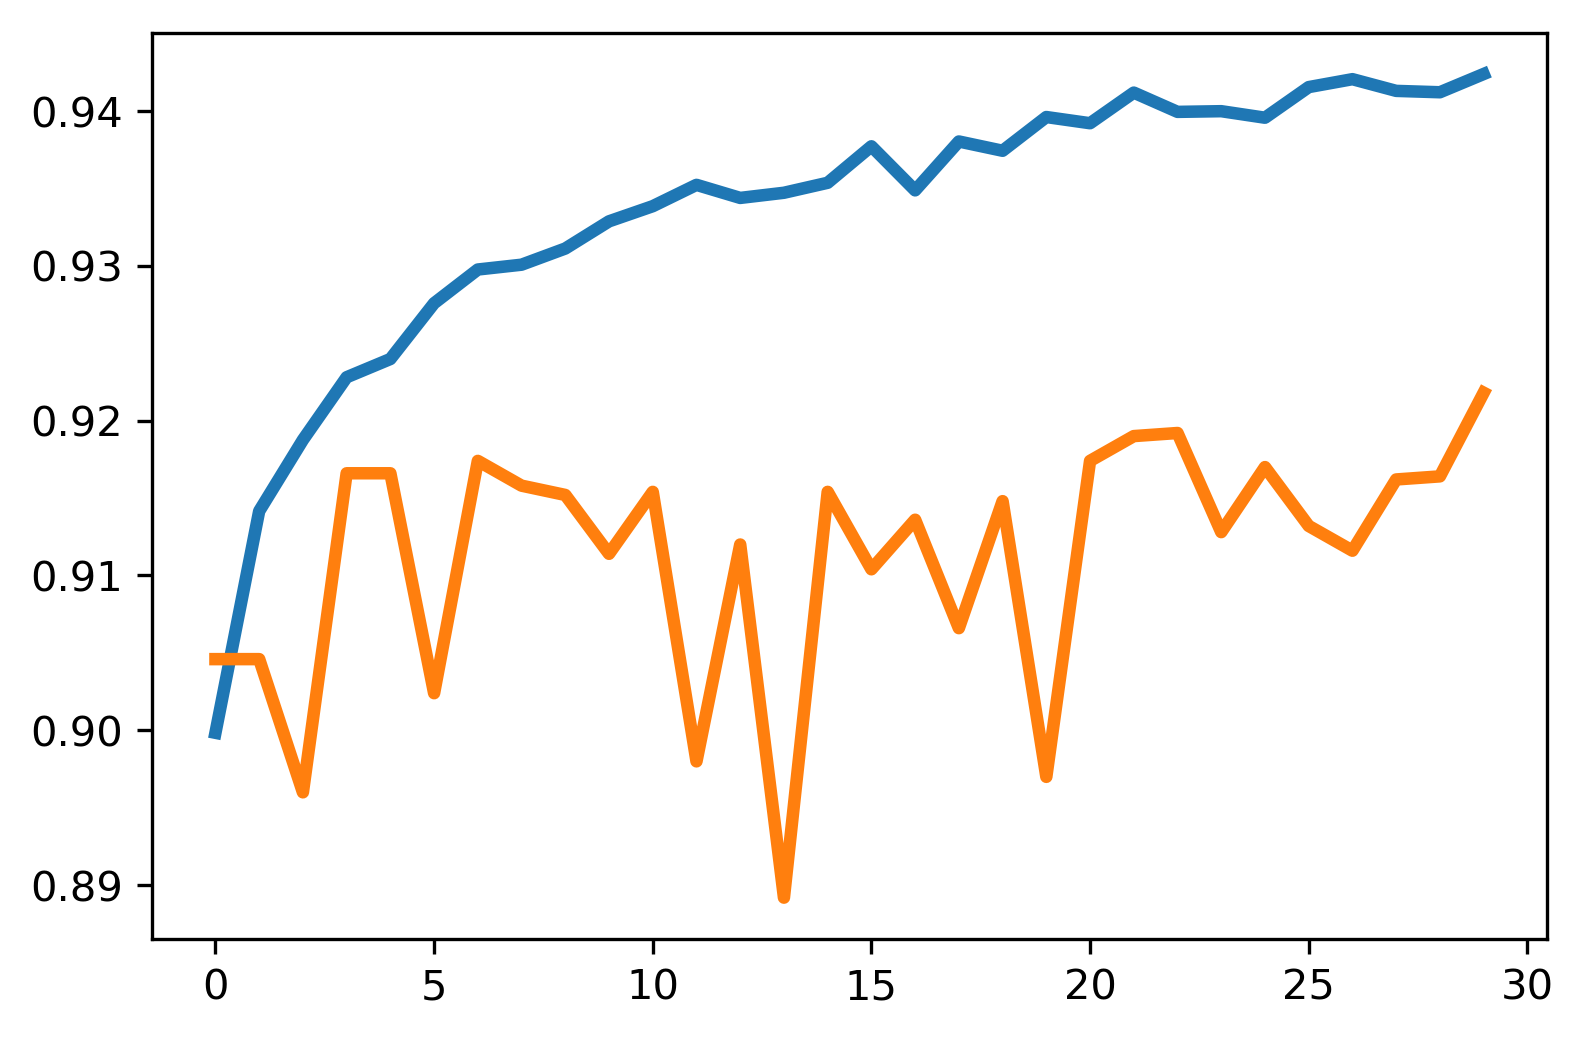

In [33]:
fig=plt.figure()
plt.plot(history.history['categorical_accuracy'], linewidth=3)
plt.plot(history.history['val_categorical_accuracy'], linewidth=3)
plt.show()
#fig.savefig("Handwritten_MNIST_Fig1_Accuracy.pdf")
#fig.savefig("Handwritten_MNIST_Fig2_AccuracyAndValidation.pdf")
#fig.savefig("Handwritten_MNIST_Fig4_100_50_DropOut_AccuracyAndValidation.pdf")

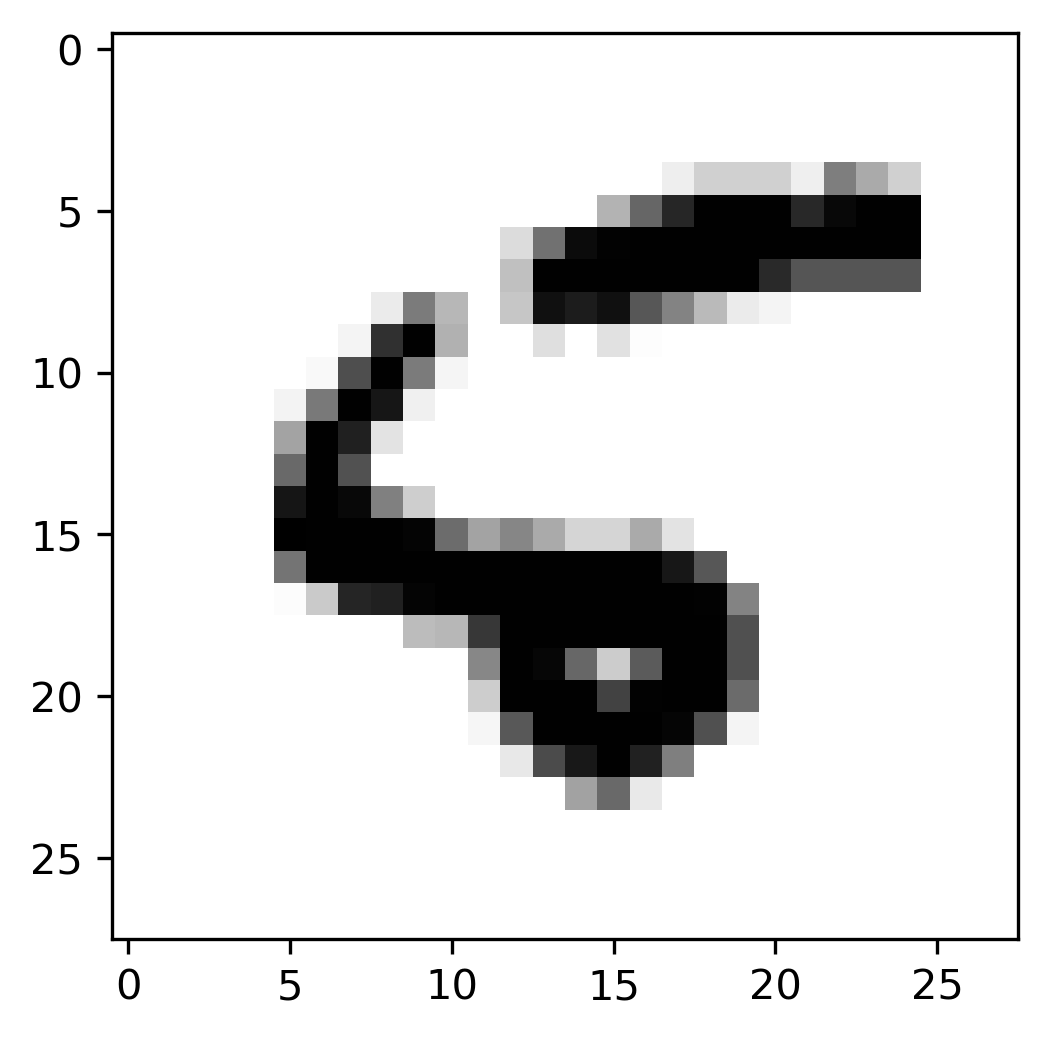

True  5  - Predicted  6  with prob.  0.999982


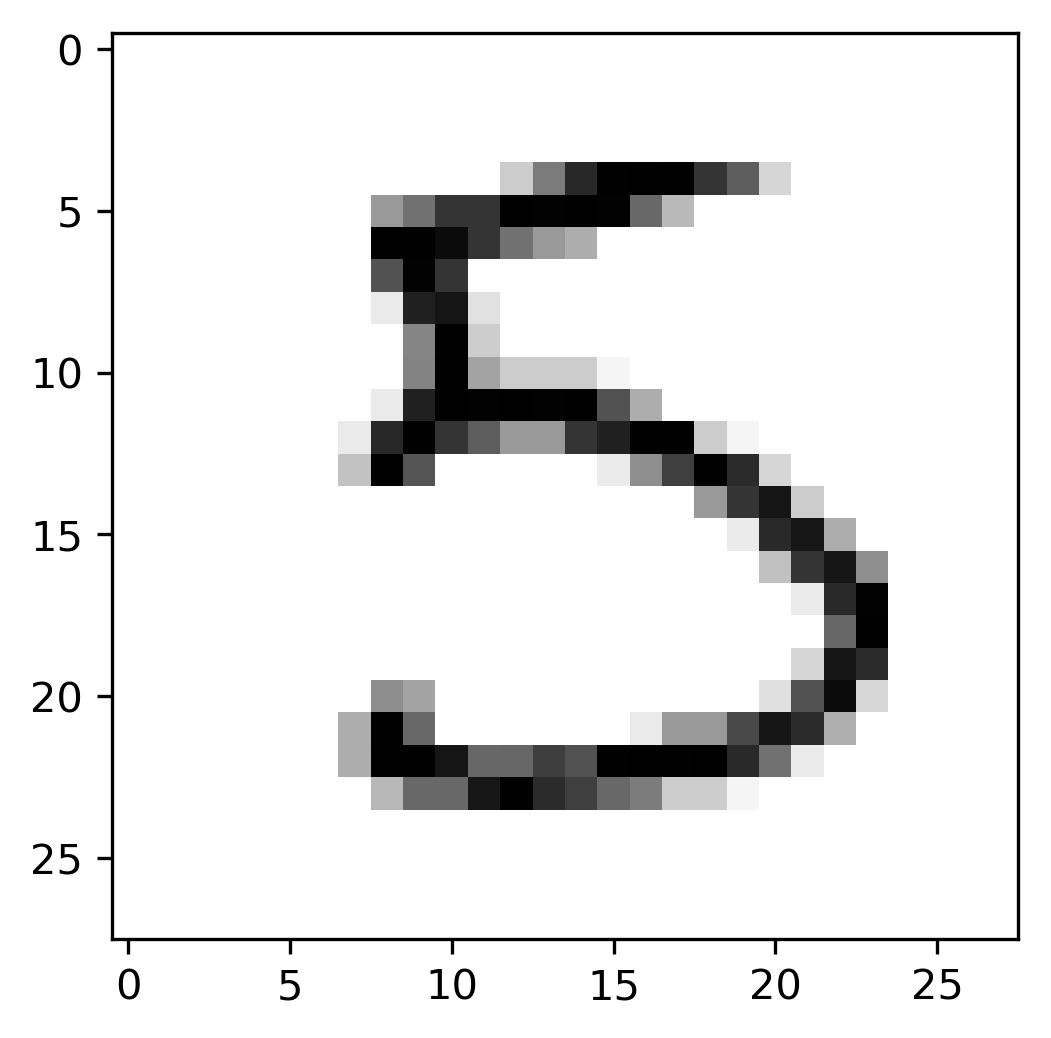

True  5  - Predicted  3  with prob.  0.54224753


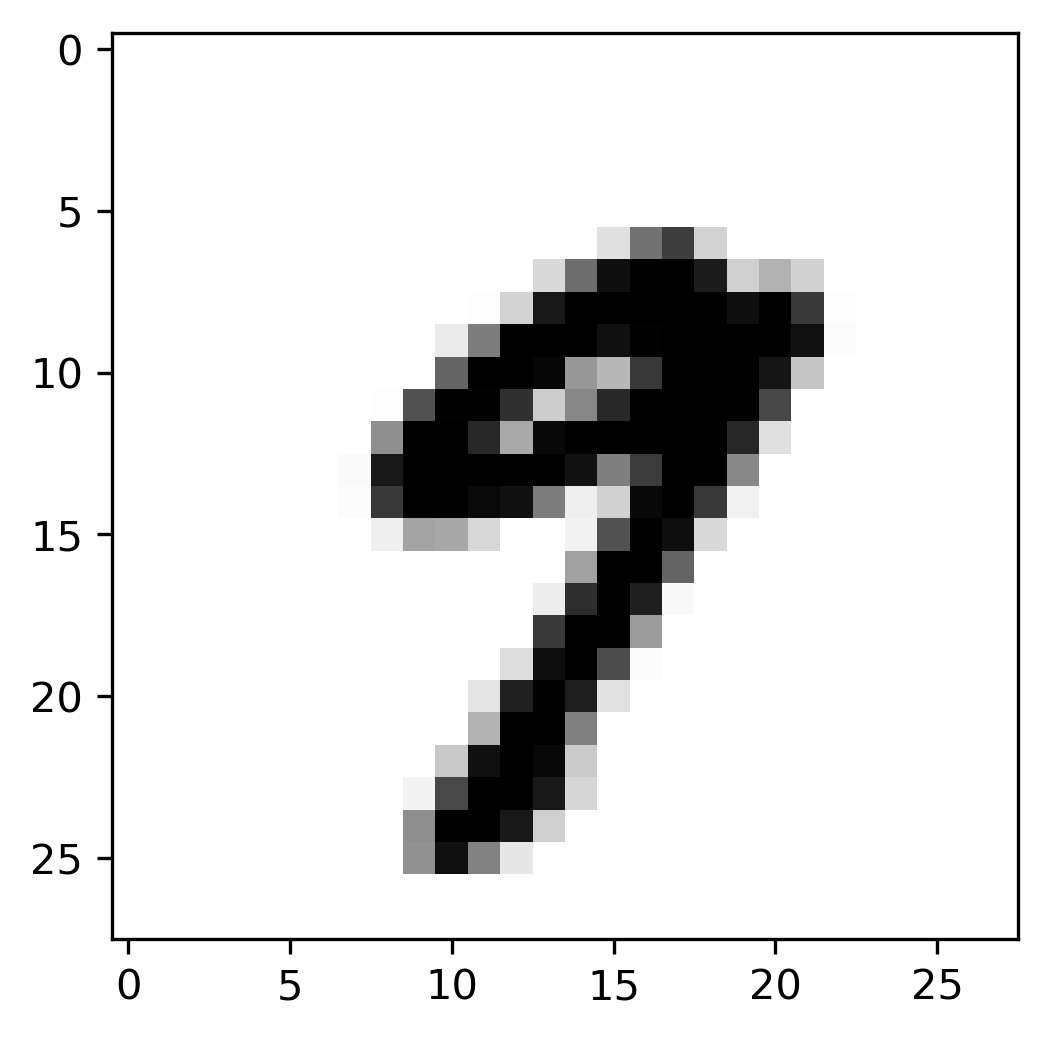

True  9  - Predicted  7  with prob.  0.7327373


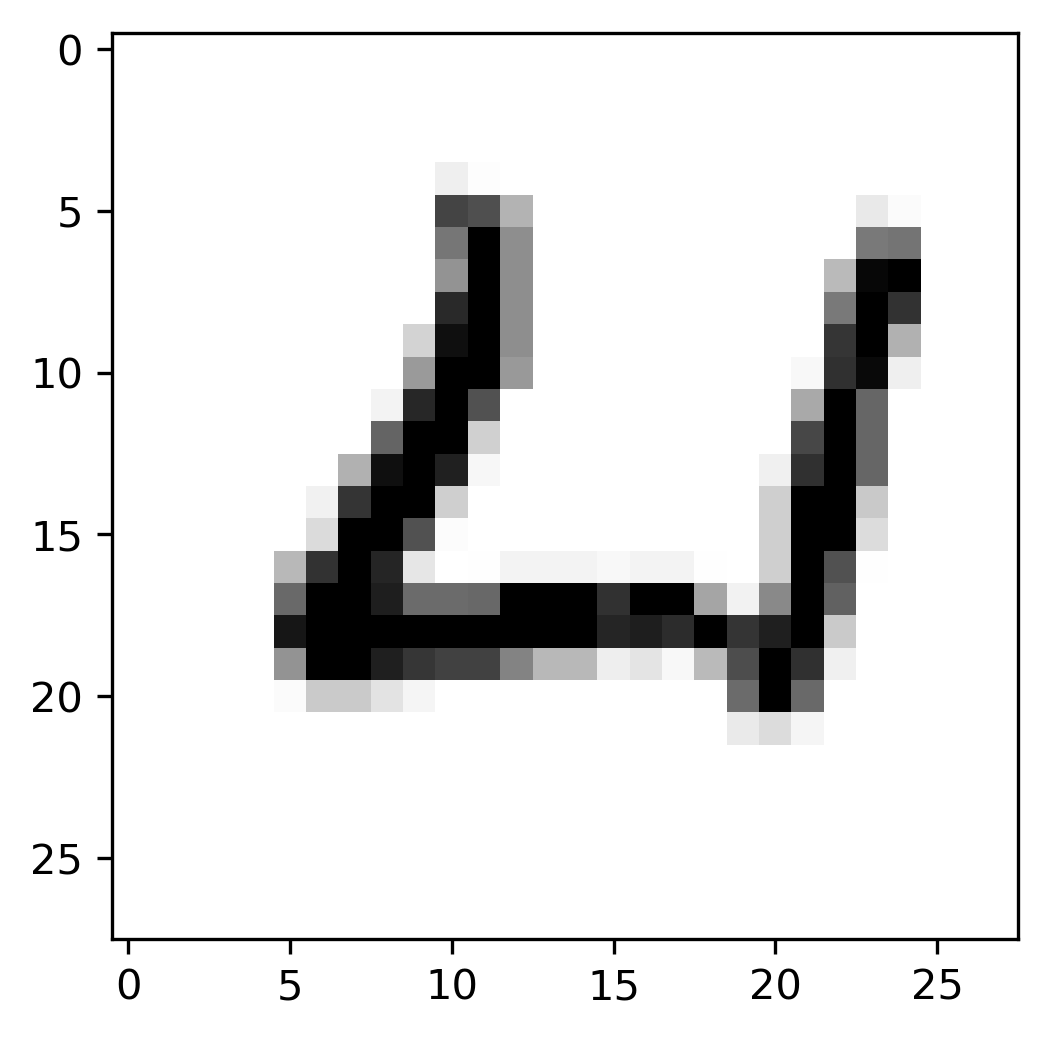

True  4  - Predicted  0  with prob.  0.47136846


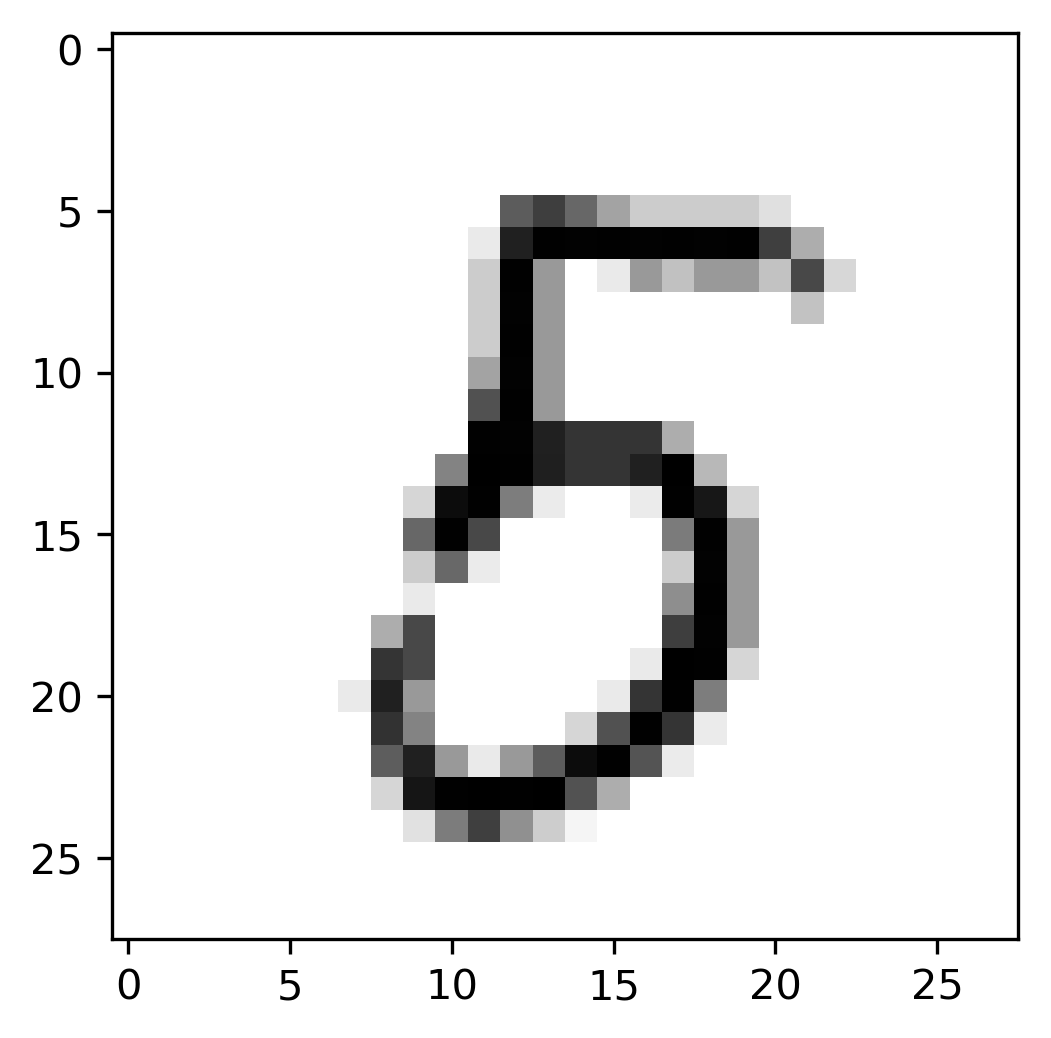

True  5  - Predicted  3  with prob.  0.7615138


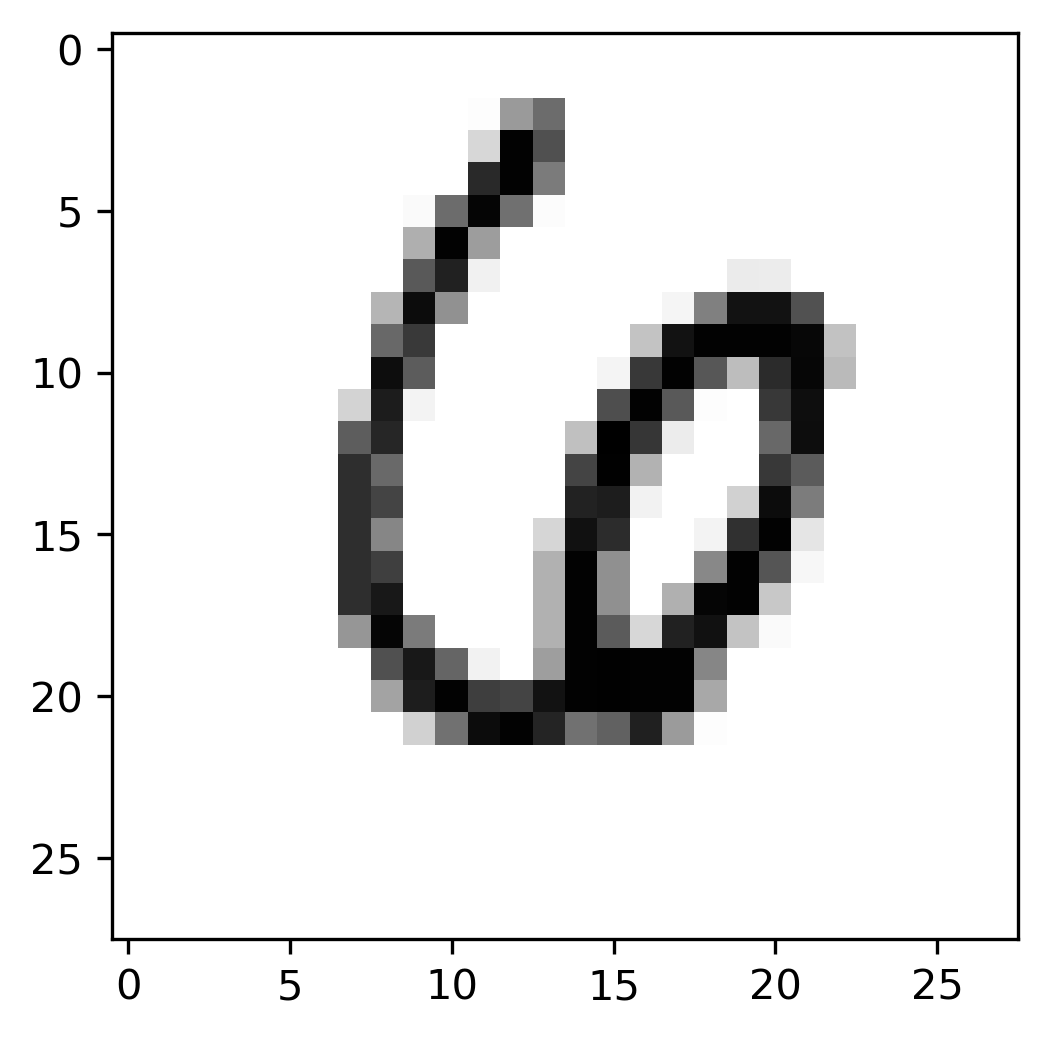

True  6  - Predicted  8  with prob.  0.8517948


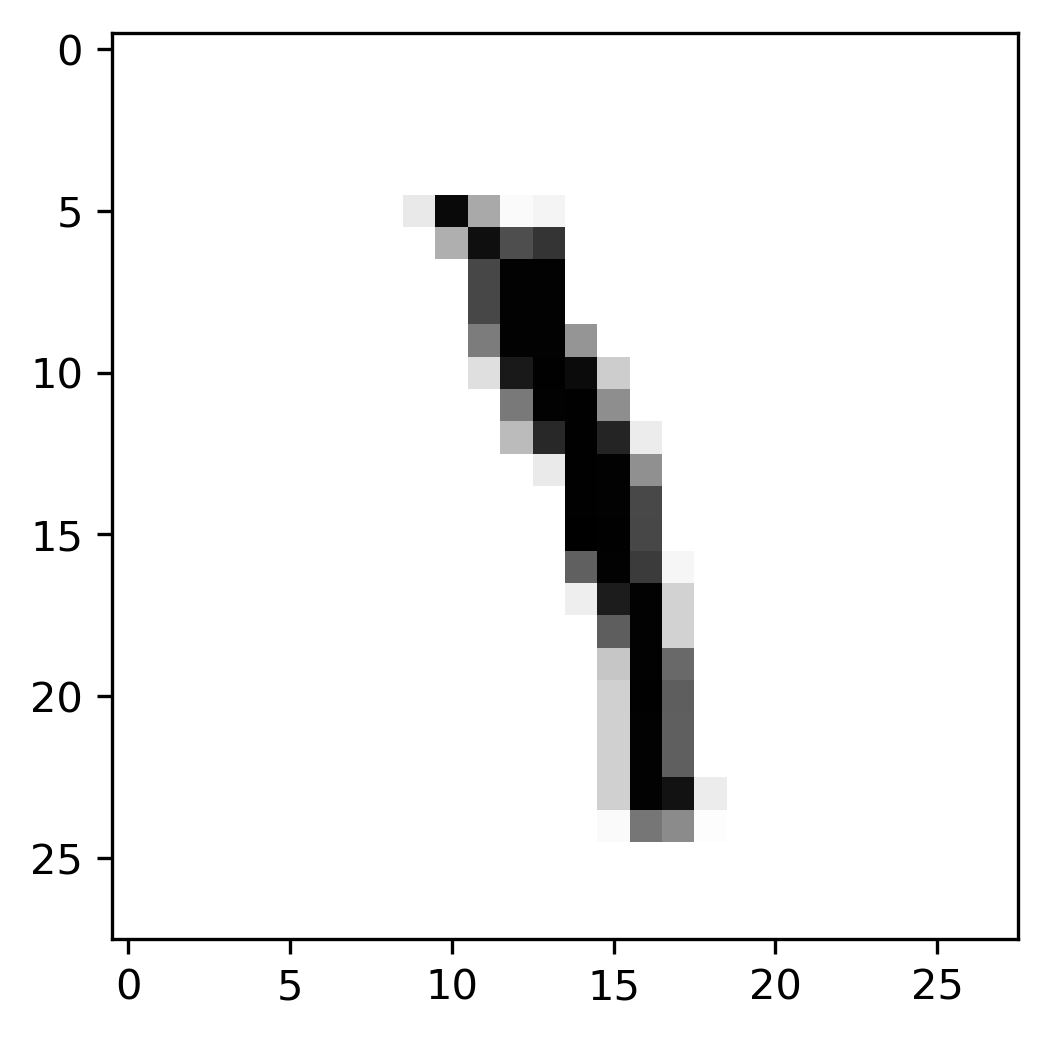

True  1  - Predicted  9  with prob.  0.89239544


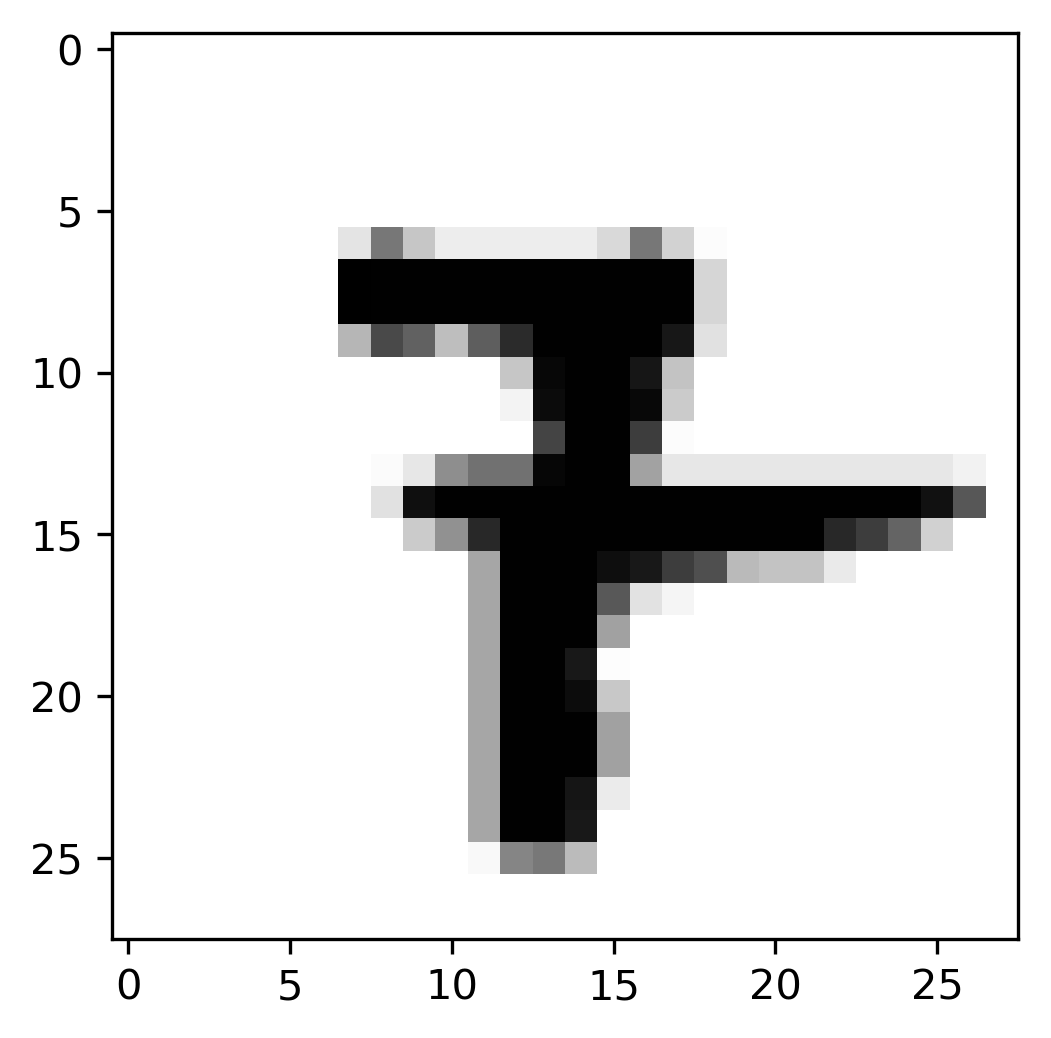

True  7  - Predicted  3  with prob.  0.44986218


In [34]:
display_mistakes(100)